In [2]:
#from keras.preprocessing import sequence
#from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D
from keras.models import load_model
import os
import numpy as np

/Users/cricket/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


https://github.com/lemuelbarango/dog-breed-classifier/blob/master/setup.ipynb

https://github.com/saksham789/DOG-BREED-CLASSIFICATION-STANFORD-DOG-DATASET  
http://course.fast.ai/lessons/lessons.html


https://github.com/lemuelbarango/dog-breed-classifier  
https://github.com/stormy-ua/dog-breeds-classification  
https://towardsdatascience.com/dog-breed-classification-hands-on-approach-b5e4f88c333e  
https://github.com/saksham789/DOG-BREED-CLASSIFICATION-STANFORD-DOG-DATASET

https://github.com/Arsey/keras-transfer-learning-for-oxford102/blob/master/bootstrap.py  
https://github.com/anujshah1003/Transfer-Learning-in-keras---custom-data/blob/master/transfer_learning_vgg16_custom_data.py  
https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/  
https://github.com/tzutalin/ImageNet_Utils  

# Folder setting

In [5]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/'
num_classes = 120
image_size = 224
num_channels = 3
np.random.seed(133)

In [3]:
def file_create(path):
    if  not os.path.exists(path):
        os.mkdir(os.path.join(os.getcwd(), *path.split('/')))

In [6]:
from six.moves.urllib.request import urlretrieve
def downloadfile(filename, targetloc='..', url=url):
    dest_filename = os.path.join(targetloc, filename)
    filename, _ = urlretrieve(url + filename, dest_filename)
    print(dest_filename, 'created')
    return filename

In [5]:
import tarfile
import sys
def extract(filename, target, location = '..'):
    
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(target)
    tar.close()
    print(filename, 'created')

In [6]:
# Folder creation
file_create('../data')
file_create('../images')
file_create('../Annotation')
file_create('../lists')
file_create('../features')
file_create('../data/train')
file_create('../data/test')
file_create('../data/cropped')
file_create('../data/cropped/train')
file_create('../data/cropped/test')

In [3]:
#download files
downloadfile('lists.tar')
downloadfile('annotation.tar')
downloadfile('images.tar')
#downloadfile('train_data.mat', targetloc = '../features')
#downloadfile('test_data.mat', targetloc = '../features')

NameError: name 'downloadfile' is not defined

In [8]:
#Extract files
extract('../lists.tar', '../lists/')
extract('../annotation.tar', '..')
extract('../images.tar', '..')


../lists.tar created
../annotation.tar created
../images.tar created


In [9]:
images_filename = '../Images'
annotation_filename = '../Annotation'

# dataset re-ordering

In [10]:
import scipy.io as sio
test_list = sio.loadmat('../lists/test_list.mat')['file_list']
train_list = sio.loadmat('../lists/train_list.mat')['file_list']

In [11]:
#create empty folders
images_folders = [folder for folder in os.listdir('../Images')if os.path.isdir(os.path.join('../Images', folder))]

rootdir='../data'
for folder in images_folders:
    os.makedirs(os.path.join(rootdir, 'train', folder))#"train/"+folder.split("\\")[-1])
    os.makedirs(os.path.join(rootdir, 'test', folder))
    os.makedirs(os.path.join(rootdir, 'cropped/train', folder))
    os.makedirs(os.path.join(rootdir, 'cropped/test', folder))

In [12]:
import shutil
def move_data_files(image_list, new_folder, copy='../Images'):
    for file in image_list:
        if os.path.exists(os.path.join(copy, file[0][0])):
            shutil.move(os.path.join(copy, file[0][0]), os.path.join(new_folder, file[0][0]))
        elif not os.path.exists(os.path.join(copy, file[0][0])):
            print('%s does not exist, it may be missing' % os.path.exists(os.path.join(copy, file[0][0])))
    return [os.path.join(new_folder, folder) for folder in os.listdir(new_folder) if os.path.isdir(os.path.join(new_folder, folder))]

In [13]:
test_folders = move_data_files(test_list, new_folder='../data/test')
train_folders = move_data_files(train_list, new_folder='../data/train')

# dataset creation

In [14]:
import imageio
from xml.dom import minidom
from skimage import transform
def load_breed(folder):
    """
    Load the data for a single breed label.
    """
    serie = folder.split('/')[2]
    breed = folder.split('/')[-1]
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), num_channels, image_size, image_size), dtype=np.float32)
    num_images = 0
    
    for image in image_files:
        #print(os.path.join('../data/cropped', serie, breed, image))
        image_file = os.path.join(folder, image)
        
        try:
            image_data = imageio.imread(image_file)[:,:,:3]
            
            annon_file = annotation_filename + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]
            new_image_data = transform.resize(new_image_data, (image_size, image_size), mode='reflect')
            
            imageio.imwrite(os.path.join('../data/cropped', serie, breed, image), new_image_data)#'../cropped/' + folder + '/' + image, new_image_data)
            dataset[num_images, :, :, :] = new_image_data.swapaxes(1,2).swapaxes(0,1)[1]
            num_images += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :, :]

    print('Full dataset tensor:', dataset.shape)
    return dataset

#load_breed('../data/train/n02085782-Japanese_spaniel')

In [15]:
from six.moves import cPickle as pickle
def maybe_pickle(data_folders, force=False):
    dataset_names = []
    for folder in data_folders:
        print(folder)
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_breed(folder)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

In [16]:
train_datasets = maybe_pickle(train_folders, force=True)
test_datasets = maybe_pickle(test_folders, force=True)

../data/train/n02085620-Chihuahua
Pickling ../data/train/n02085620-Chihuahua.pickle.


/Users/cricket/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


Full dataset tensor: (100, 3, 224, 224)
../data/train/n02085782-Japanese_spaniel
Pickling ../data/train/n02085782-Japanese_spaniel.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02085936-Maltese_dog
Pickling ../data/train/n02085936-Maltese_dog.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02086079-Pekinese
Pickling ../data/train/n02086079-Pekinese.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02086240-Shih-Tzu
Pickling ../data/train/n02086240-Shih-Tzu.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02086646-Blenheim_spaniel
Pickling ../data/train/n02086646-Blenheim_spaniel.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02086910-papillon
Pickling ../data/train/n02086910-papillon.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02087046-toy_terrier
Pickling ../data/train/n02087046-toy_terrier.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02087394-Rhodesian_ridgeback
Pickling ..

../data/train/n02100735-English_setter
Pickling ../data/train/n02100735-English_setter.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02100877-Irish_setter
Pickling ../data/train/n02100877-Irish_setter.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02101006-Gordon_setter
Pickling ../data/train/n02101006-Gordon_setter.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02101388-Brittany_spaniel
Pickling ../data/train/n02101388-Brittany_spaniel.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02101556-clumber
Pickling ../data/train/n02101556-clumber.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02102040-English_springer
Pickling ../data/train/n02102040-English_springer.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02102177-Welsh_springer_spaniel
Pickling ../data/train/n02102177-Welsh_springer_spaniel.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02102318-cocker_spaniel
Pickling ../

/Users/cricket/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [53.07989615453476, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Full dataset tensor: (100, 3, 224, 224)
../data/train/n02106030-collie
Pickling ../data/train/n02106030-collie.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02106166-Border_collie
Pickling ../data/train/n02106166-Border_collie.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02106382-Bouvier_des_Flandres
Pickling ../data/train/n02106382-Bouvier_des_Flandres.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02106550-Rottweiler
Pickling ../data/train/n02106550-Rottweiler.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02106662-German_shepherd
Pickling ../data/train/n02106662-German_shepherd.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02107142-Doberman
Pickling ../data/train/n02107142-Doberman.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02107312-miniature_pinscher
Pickling ../data/train/n02107312-miniature_pinscher.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/train/n02107574-Greater

Full dataset tensor: (96, 3, 224, 224)
../data/test/n02091635-otterhound
Pickling ../data/test/n02091635-otterhound.pickle.
Full dataset tensor: (51, 3, 224, 224)
../data/test/n02091831-Saluki
Pickling ../data/test/n02091831-Saluki.pickle.
Full dataset tensor: (100, 3, 224, 224)
../data/test/n02092002-Scottish_deerhound
Pickling ../data/test/n02092002-Scottish_deerhound.pickle.
Full dataset tensor: (132, 3, 224, 224)
../data/test/n02092339-Weimaraner
Pickling ../data/test/n02092339-Weimaraner.pickle.
Full dataset tensor: (60, 3, 224, 224)
../data/test/n02093256-Staffordshire_bullterrier
Pickling ../data/test/n02093256-Staffordshire_bullterrier.pickle.
Full dataset tensor: (55, 3, 224, 224)
../data/test/n02093428-American_Staffordshire_terrier
Pickling ../data/test/n02093428-American_Staffordshire_terrier.pickle.
Full dataset tensor: (64, 3, 224, 224)
../data/test/n02093647-Bedlington_terrier
Pickling ../data/test/n02093647-Bedlington_terrier.pickle.
Full dataset tensor: (82, 3, 224, 22

../data/test/n02107142-Doberman
Pickling ../data/test/n02107142-Doberman.pickle.
Full dataset tensor: (50, 3, 224, 224)
../data/test/n02107312-miniature_pinscher
Pickling ../data/test/n02107312-miniature_pinscher.pickle.
Full dataset tensor: (84, 3, 224, 224)
../data/test/n02107574-Greater_Swiss_Mountain_dog
Pickling ../data/test/n02107574-Greater_Swiss_Mountain_dog.pickle.
Full dataset tensor: (68, 3, 224, 224)
../data/test/n02107683-Bernese_mountain_dog
Pickling ../data/test/n02107683-Bernese_mountain_dog.pickle.
Full dataset tensor: (118, 3, 224, 224)
../data/test/n02107908-Appenzeller
Pickling ../data/test/n02107908-Appenzeller.pickle.
Full dataset tensor: (51, 3, 224, 224)
../data/test/n02108000-EntleBucher
Pickling ../data/test/n02108000-EntleBucher.pickle.
Full dataset tensor: (102, 3, 224, 224)
../data/test/n02108089-boxer
Pickling ../data/test/n02108089-boxer.pickle.
Full dataset tensor: (51, 3, 224, 224)
../data/test/n02108422-bull_mastiff
Pickling ../data/test/n02108422-bull

# dataset formatting

In [17]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, num_channels, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [18]:
def merge_datasets(pickle_files, train_size, valid_size=0, even_size=True):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                breed_set = pickle.load(f)
                np.random.shuffle(breed_set)
                
            if not even_size:
                tsize_per_class,end_l = len(breed_set),len(breed_set)
                end_t = start_t + tsize_per_class
                
            if valid_dataset is not None:
                valid_breed = breed_set[:vsize_per_class, :, :, :]
                valid_dataset[start_v:end_v, :, :, :] = valid_breed
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class

            
            train_breed = breed_set[vsize_per_class:end_l, :, :, :]
            train_dataset[start_t:end_t, :, :, :] = train_breed
            train_labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

In [19]:
train_size = 9600
valid_size = 2400
test_size = 8580

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size, even_size=False)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (9600, 3, 224, 224) (9600,)
Validation: (2400, 3, 224, 224) (2400,)
Testing: (8580, 3, 224, 224) (8580,)


# Dataset saving

In [21]:
np.savez('../train_dataset.npz', train_dataset)
np.savez('../train_labels.npz', train_labels)
np.savez('../valid_dataset.npz', valid_dataset)
np.savez('../valid_labels.npz', valid_labels)
np.savez('../test_dataset.npz', test_dataset)
np.savez('../test_labels.npz', test_labels)

In [90]:
from keras.preprocessing import image
i=image.load_img('../data/test/n02085620-Chihuahua/n02085620_588.jpg',target_size=(229,229))
image.img_to_array(i).shape

(229, 229, 3)

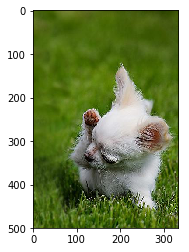

In [101]:
import imageio
from matplotlib.pyplot import imshow
a=imageio.imread('../data/test/n02085620-Chihuahua/n02085620_588.jpg')[:,:,:3]
imshow(a)

In [7]:
import scipy.io as sio
downloadfile('test_data.mat', targetloc = '../features')
test_data = sio.loadmat('../features/test_data.mat')
#train_data = sio.loadmat('../features/train_data.mat')

../features/test_data.mat created


In [8]:
test_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'test_info', 'test_fg_data', 'test_data'])

In [9]:
test_data['test_data']

array([[0.42297642, 0.44567102, 0.44322268, ..., 0.11023967, 0.28878223,
        0.16612349],
       [0.4346575 , 0.36657143, 0.37279967, ..., 0.22414799, 0.30590121,
        0.25217826],
       [0.41025734, 0.45473016, 0.42543391, ..., 0.15453042, 0.32431428,
        0.20263375],
       ...,
       [0.28498557, 0.20938963, 0.24384632, ..., 0.49464286, 0.32798978,
        0.47575572],
       [0.39380501, 0.33590476, 0.33118885, ..., 0.2584127 , 0.34057349,
        0.31977051],
       [0.33602892, 0.2005464 , 0.21812583, ..., 0.36979167, 0.25407723,
        0.35944589]])

In [10]:
test_data['test_fg_data']

array([[2.13068182e-04, 0.00000000e+00, 7.10227273e-05, ...,
        1.06534091e-04, 7.10227273e-05, 1.74005682e-03],
       [0.00000000e+00, 8.40336134e-04, 6.53594771e-04, ...,
        1.40056022e-04, 7.93650794e-04, 1.40056022e-03],
       [7.55857899e-05, 0.00000000e+00, 1.51171580e-04, ...,
        3.77928949e-05, 7.55857899e-05, 3.17460317e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.34375000e-04, ...,
        3.55468750e-03, 3.90625000e-05, 2.73437500e-04],
       [0.00000000e+00, 8.92857143e-05, 0.00000000e+00, ...,
        1.78571429e-04, 7.14285714e-04, 1.11607143e-03],
       [6.72043011e-05, 0.00000000e+00, 0.00000000e+00, ...,
        1.71370968e-03, 2.15053763e-03, 8.73655914e-04]])

In [4]:
#Dataset loading model and lists
test_data = sio.loadmat('../model/test_data.mat')
train_data = sio.loadmat('../model/train_data.mat')

file_list = sio.loadmat('../lists/file_list.mat')
test_list = sio.loadmat('../lists/test_list.mat')
train_list = sio.loadmat('../lists/train_list.mat')

In [6]:
test_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'test_info', 'test_fg_data', 'test_data'])

In [7]:
file_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])